<a href="https://colab.research.google.com/github/gccianmario/Online-learning-application-projects/blob/main/Ola_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auxiliary functions

In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt

In [2]:
# it return a random list of probabilities that sum to 1-padding
def get_probabilities(quantity, padding = 0.5):
  if int(quantity) <= 0 :
    raise Exception("quantity Value Error")
  if float(padding) < 0  or float(padding) >= 1:
    raise Exception("padding Value Error")
  
  probabilities = []
  random_samples = np.array([0] * quantity)

  for i in range(quantity):
    random_samples[i] = float(randint(1, 100))
  
  normalizer = (1 - padding) / np.sum(random_samples)

  for i in range(quantity):
    probabilities.append(random_samples[i] * normalizer)

  # add numerical noise to first element to try to ensure sum to 1-padding
  probabilities[0] = probabilities[0] + ((1-padding) - np.sum(probabilities))
  
  return probabilities

example function to generate n probabilities that sum to 1-padding

In [3]:
test = get_probabilities(5, padding=0.9)
print(test)
print(f"sum to: {np.sum(test)}")

[0.029078014184397157, 0.015248226950354606, 0.013120567375886521, 0.028014184397163112, 0.014539007092198578]
sum to: 0.09999999999999998


#Graph implementation

Graph is fully connected and therefore all the edges have strictly positive probabilities (in practice the secondary products displayed are just two and thus many of the edges are useless). In the second, assume that the graph is not fully connected and therefore some edges have zero probability. 

The behavior of the user in the graph is similar to that of the social influence. Thus, in the following project proposals, you need to resort to social influence techniques to evaluate the probabilities with which the user reaches the webpage with some specific primary product


In [4]:
class Graph:
  def __init__(self):
    self.graph = {}
    self.node_list = []
  
  # Add an edge to the graph  src: [(dest, weight)...]
  def add_edge(self, src, dest, weight):
    if not isinstance(src, Product):
      raise Exception("source of edge Value Error")
    if not isinstance(dest, Product):
      raise Exception("destination of edge Value Error")

    self.graph[src].append((dest, weight))
  
  # Add a node to the graph
  def add_node(self, item):
    if not isinstance(item, Product):
      raise Exception("item is not a product Value Error")
    if(item in self.graph):
      print("Item already in the graph")
      return
    
    self.graph[item] = list()
    self.node_list.append(item)

  # get all child nodes given a father
  def get_child_nodes(self, father_node):
    if not isinstance(father_node, Product):
      raise Exception("node is not a product Value Error")
    if(father_node not in self.graph):
      print("No match")
      return []
    
    return self.graph[father_node]

  # get all nodes
  def get_all_nodes(self):
    return [*self.graph]

  # Function to print adjacency list representation 
  def printGraph(self):
    for (src, node_list) in self.graph.items():
      print(f"--- node: {src} ---")
      for (node, weight) in node_list:
        print(f"\t( {src} )--[w:{weight:.3f}]-—>( {node} )")


  def recursive_visit(self, graph, start_node, node, node_prob, prob_list, purchased_set, secondary_list, expected_profits, user):
    
    if node.id not in secondary_list or node in purchased_set:
      # stop in case this is not the second product or user already bought this
      return

    # update probability trace of the path leading to this point (all weights between root and this node & eventual lambda effects )
    prob_list.append(node_prob)
    if node.id == secondary_list[1]:
      prob_list.append(user.lmbda)

    #decide whether to buy
    if(user.reservation_prices[node.id-1] >= node.price):

        prob_to_be_here = np.prod(np.array(prob_list))  # cumulative probability to be in this node of the graph
        
        expected_profits[start_node.id][node.id-1] += prob_to_be_here * node.price * user.exp_number_purchase[node.id-1]  # compute profit of this purchase
        purchased_set.add(node)
        print(f"user {user.id} with rp {user.reservation_prices[node.id-1]} BOUGHT {user.exp_number_purchase[node.id-1]} units of product {node.id} for {node.price}, probability:{prob_to_be_here}")

        for child, weight in graph.get_child_nodes(node): # for every child of the node try to start a recursive visit
          self.recursive_visit(
                    graph=graph,
                    start_node=start_node,
                    node=child,
                    node_prob=weight,
                    prob_list=prob_list,
                    purchased_set=purchased_set,
                    secondary_list=node.secondary_list,
                    expected_profits= expected_profits,
                    user=user
                    )


    prob_list.remove(node_prob)
    if node.id == secondary_list[1]:
      prob_list.remove(user.lmbda)

This function creates a fully connected graph with the given weight using random probability weights

In [5]:
def random_fully_connected_graph(products=[]):
  graph = Graph()

  for prod in products:
    graph.add_node(prod)
  
  for prod in products:
    weights = get_probabilities(4, padding=0.1) # to change weights change here
    child_products = products.copy()
    child_products.remove(prod)
    
    for i, prod_child in enumerate(child_products):
      graph.add_edge(prod, prod_child, weights[i])
      
  return graph

# User, Campaign, Product Class definition

In [6]:
class Knapsack:

    def __init__(self, rewards, budgets):
        # initialize rewards vector
        self.rewards = rewards

        # initialize budgets vector
        self.budgets = budgets

        self.allocations = np.zeros((rewards.shape[0] + 1, rewards.shape[1], rewards.shape[0]+1), dtype = float)

        # initialize dynamic programming table, dimensions: (subcampaigns + 1, budgets)
        self.dp_table = np.zeros((len(self.rewards) + 1, len(self.budgets)), dtype = float)

    def solve(self):
        n_rows = self.dp_table.shape[0]
        n_columns = self.dp_table.shape[1]
        # cycle for each row of the dp_table
        new_alloc_index1 = -1
        for row in range(1, n_rows):
            # cycle for each row of the dp_table

            # self.allocations[row] = self.allocations[row - 1]

            for column in range(n_columns):
                # initialize max value for each cell to minus infinity
                max_value = -100
                # cycle through each column until the current one (included, that's why there is a +1)

                # set table entry to -100 in case of infeasible budget for the new sub campaign considered and
                # previous sub campaign considered.
                if self.rewards[row-1][column] <= 0 and self.dp_table[row - 1][column] <= 0:

                    self.dp_table[row][column] = -100
                    continue

                for index in range(column + 1):
                    # the current value is the sum of the subcampaign reward associated to [index] and the value of
                    # the dp table associated to [previous row][column-index]
                    # this way the sum is always equal to the budget expressed by the column

                    if self.dp_table[row - 1][column - index] >= 0 and self.rewards[row - 1][index] >= 0:
                        current_value = self.rewards[row - 1][index] + self.dp_table[row - 1][column - index]
                    else:
                        if self.rewards[row - 1][index] >= 0:
                            current_value = self.rewards[row - 1][index]
                        else:
                            current_value = self.dp_table[row - 1][column]

                        # update max value
                    if current_value > max_value:
                            max_value = current_value
                            allocation = np.copy(self.allocations[row-1][column-index])
                            allocation[row] = self.budgets[index]

                            # self.allocations[row][column]

                # update max value in the dp table

                if row > 0:
                    self.allocations[row][column] = allocation

                self.dp_table[row][column] = max_value

In [7]:
class Product:
  def __init__(self, id, price, secondary_list = []):
    self.id = id
    self.price = price  # correspond to margin
    self.secondary_list = secondary_list  # what to display after purchase (fixed)
  
  def __str__(self):
    return f"Product {self.id}"

  def add_secondary(self, product):
    self.secondary_list.append(product)
  

In [32]:
class User:
  def __init__(self, 
               id, 
               reservation_prices, 
               lmbda, 
               weighted_graph, 
               alpha_functions, 
               exp_number_purchase, 
               #expected_profits,
               ):
    self.id = id
    self.reservation_prices = reservation_prices
    self.lmbda = lmbda
    self.weighted_graph = weighted_graph  # pass here the full weighted graph associated with the user
    self.alpha_function = alpha_functions  # list of alpha_function specifing how the user react to a specific campaign
    self.exp_number_purchase = exp_number_purchase


    # Spostare logica fuori?
    """self.expected_profits = expected_profits.copy() # dict: key -> starting product, value -> expected profits
    self._simulation_done = False
    self._knapsack = None"""

  """  def value_per_click(self, product):
      if self._simulation_done:
        return sum(self.expected_profits[product])
      else:
        raise Exception("Must run simulation first")"""   # Questa la gestirei fuori dagli user per adattarla al problema da risolvere
    
  
  def set_graph(self, weighted_graph):
    self.weighted_graph = weighted_graph

  """  def __clear_expected_profits(self):
        for key in self.expected_profits:
          lenght = len(self.expected_profits[key])
          self.expected_profits[key] = [0 for _ in range(0, lenght)]


  def build_knapsack(self, budgets, forbidden_configs):
    if self._simulation_done:
      rows = len(self.alpha_function)
      columns = len(budgets)
      rewards = np.empty(shape= (rows, columns), dtype = np.float32)

      for row in range(rows):
        for column in range(columns):
          if (row, column) in forbidden_configs[row]:
            rewards[row][column] = -100
          else:
            rewards[row][column] = self.value_per_click(product = row+1) * (max(self.alpha_function[row](x = budgets[column]), 0.0))
      self._knapsack = Knapsack(rewards = rewards, budgets = budgets)
    else:
      raise Exception("Must run simulation first")

  def solve_dp(self):
    if self._knapsack:
      self._knapsack.solve()

    else:
      raise Exception("Must initialize knapsack problem first")

    return self._knapsack.rewards, self._knapsack.dp_table, self._knapsack.allocations""" # Spostare logica fuori?


  def expected_profit(self):
    nodes = self.weighted_graph.get_all_nodes()
    expected_profits = [0, 0, 0, 0, 0]
    # self.__clear_expected_profits()
    # self._simulation_done = False

    # apply dfs starting from every product page
    for i, node in enumerate(nodes):
      purchased_set = set() # keep track of the purchased products
      prob_list = [1]       # list with the trace of probabilities collected

      recursive_visit(graph= self.weighted_graph,
                      root_id=i,
                      node= node,
                      node_prob= 1,
                      prob_list= prob_list,
                      purchased_set= purchased_set,
                      secondary_list= [node.id, -1],
                      expected_profits= expected_profits,
                      user=self
                      )
      
      #self._simulation_done = True
      
      print(f"\t\t$$$ Expected profit of visited products: {expected_profits[node.id-1]} $$$")
      print(f"\t\t--- End navigation started from {node} ---\n")
      # print(f"\t\t--- Expected profit of visit: {self.value_per_click(node.id)} ---\n")
    
    return expected_profits
  

Recursive algorithm used to emulate the user experience

In [26]:
def recursive_visit(graph, root_id, node, node_prob, prob_list, purchased_set, secondary_list, expected_profits, user):
  
  if node.id not in secondary_list or node in purchased_set:
    # stop in case this is not the second product or user already bought this
    return

  # update probability trace of the path leading to this point (all weights between root and this node & eventual lambda effects )
  prob_list.append(node_prob)
  if node.id == secondary_list[1]:
    prob_list.append(user.lmbda)

  #decide whether to buy
  if(user.reservation_prices[node.id-1] >= node.price):

    prob_to_be_here = np.prod(np.array(prob_list))  # cumulative probability to be in this node of the graph
    expected_profits[root_id] += prob_to_be_here * node.price * user.exp_number_purchase[node.id-1]  # compute profit of this purchase
    purchased_set.add(node)
    print(f"user {user.id} with rp {user.reservation_prices[node.id-1]} BOUGHT {user.exp_number_purchase} units of product {node.id} for {node.price}, probability:{prob_to_be_here}")

    for child, weight in graph.get_child_nodes(node): # for every child of the node try to start a recursive visit
      recursive_visit(
                graph=graph,
                root_id=root_id,
                node=child,
                node_prob=weight,
                prob_list=prob_list,
                purchased_set=purchased_set,
                secondary_list=node.secondary_list,
                expected_profits= expected_profits,
                user=user
                )


  prob_list.remove(node_prob)
  if node.id == secondary_list[1]:
    prob_list.remove(user.lmbda)


In [11]:
class Campaign:
  def __init__(self, id, allocated_budget, value_per_click, alpha_i_max):
    self.id = id
    self.allocated_budget = allocated_budget
    self.value_per_click = value_per_click
    self.alpha_i_max = alpha_i_max

  def change_budget(self, new_budget):
    self.allocated_budget = new_budget
  
  def get_alpha_i(self, user_alpha_function):
    return max(user_alpha_function(self.allocated_budget), self.alpha_i_max) # CHECK THIS POINT


# Alpha function generator and testing

this function is a generator of alpha functions based on saturation speed and value where to saturate, they are all sigmoid functions



In [12]:
def new_alpha_function(saturation_speed = 1, max_value = 1, activation=0.1):
  return lambda x: (-1 +  2 / (1 + np.exp(- saturation_speed * (x-activation))))*max_value

example on how to generate and visualize alpha_functions

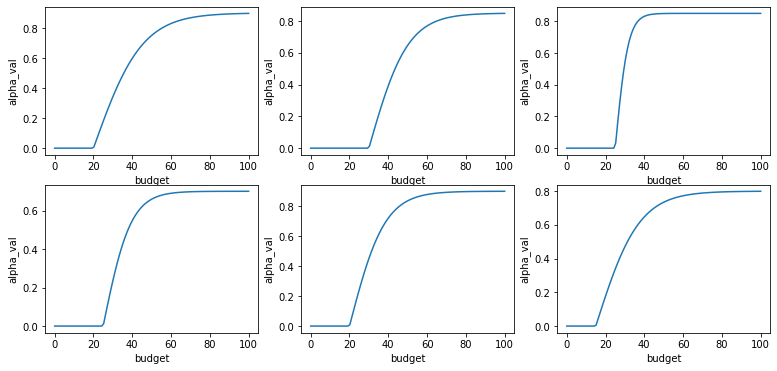

In [13]:
test_alpha = [
            new_alpha_function(saturation_speed=0.08, max_value=0.9, activation = 20),
            new_alpha_function(saturation_speed=0.1, max_value=0.85, activation = 30),
            new_alpha_function(saturation_speed=0.3, max_value=0.85, activation = 25),
            new_alpha_function(saturation_speed=0.14, max_value=0.7, activation = 25),
            new_alpha_function(saturation_speed=0.11, max_value=0.9, activation = 20),
            new_alpha_function(saturation_speed=0.09, max_value=0.8, activation = 15)  
]
img, axss = plt.subplots(nrows=2, ncols=3, figsize=((13,6)))
axs = axss.flatten()

for i in range(6):
  x = np.linspace(0,100, 100)
  y = test_alpha[i](x).clip(min=0.0)
  axs[i].set_xlabel("budget") 
  axs[i].set_ylabel("alpha_val") 
  axs[i].plot(x,y) 
img.show()

# Test Environment

Environment creation

In [33]:
# create alpha functions
""" used test_alpha from cells above  """

# create 5 products

prod1 = Product(1, 2.0, secondary_list=[2, 3])
prod2 = Product(2, 2.5, secondary_list=[3, 4])
prod3 = Product(3, 3.0, secondary_list=[1, 5])
prod4 = Product(4, 4.0, secondary_list=[2, 5])
prod5 = Product(5, 4.5, secondary_list=[1, 4])

products = [prod1, prod2, prod3, prod4, prod5]

"""expected_profits = {1: [0,0,0,0,0], 
                    2: [0,0,0,0,0], 
                    3: [0,0,0,0,0], 
                    4: [0,0,0,0,0], 
                    5: [0,0,0,0,0]}"""

budgets = np.array([0, 10, 20, 30, 40, 50, 60, 70])

forbidden_configs = [[(0,0), (0,5), (0,6), (0,7)],  # TODO: there sould be a different one for each user
                     [(1,4),(1,5), (1,6), (1,7)],
                     [(2,5), (2,6), (2,7)],
                     [(3,0),(3,6), (3,7)],
                     [(4,0), (4,7)]]

# create 3 users

user1 = User(id = 1,
             reservation_prices=[6.0, 6.0, 6.0, 6.0, 6.0],
             lmbda=0.7,
             alpha_functions=test_alpha[:5],
             exp_number_purchase=[2.1, 2.0, 1.0, 1.0, 0.0],
             weighted_graph=random_fully_connected_graph(products),  # clarify: is the weighted graph per user or general? 
             # expected_profits = expected_profits
             )
             
user2 = User(id = 2,
             reservation_prices=[1.0, 2.0, 3.0, 4.0, 5.0],
             lmbda=0.85,
             alpha_functions=test_alpha[:5],
             exp_number_purchase=[1.4, 2.2, 1.3, 1.0, 1.1],
             weighted_graph=random_fully_connected_graph(products),
             # expected_profits = expected_profits
             )

user3 = User(id = 3,
             reservation_prices=[1.0, 3.0, 1.0, 1.5, 1.3],
             lmbda=0.6,
             alpha_functions=test_alpha[:5],
             exp_number_purchase=[3.0, 2.0, 2.1, 1.6, 1.1],
             weighted_graph=random_fully_connected_graph(products),
             # expected_profits = expected_profits
             )

users = [user1, user2, user3]


In [ ]:
graph = Graph()
# node crearion
graph.add_node(prod1)
graph.add_node(prod2)
graph.add_node(prod3)
graph.add_node(prod4)
graph.add_node(prod5)

graph.printGraph()
print("\n")

# edge creation
graph.add_edge(prod1, prod5, 3)
graph.add_edge(prod1, prod2, 3)

graph.add_edge(prod2, prod4, 3)
graph.add_edge(prod2, prod3, 3)

graph.add_edge(prod3, prod1, 3)
graph.add_edge(prod3, prod5, 3)

graph.printGraph()
print("\n")

# example random fully connected graph
print("** fully connected graph ** \n")
graph = random_fully_connected_graph(products)
graph.printGraph()

# child retrival
print("\nchilds of node 1:")
result = graph.get_child_nodes(prod1)
print([f"{node} weight:{weight}" for (node, weight) in result])

In [34]:
user1.expected_profit()

user 1 with rp 6.0 BOUGHT [2.1, 2.0, 1.0, 1.0, 0.0] units of product 1 for 2.0, probability:1
user 1 with rp 6.0 BOUGHT [2.1, 2.0, 1.0, 1.0, 0.0] units of product 2 for 2.5, probability:0.12413793103448276
user 1 with rp 6.0 BOUGHT [2.1, 2.0, 1.0, 1.0, 0.0] units of product 3 for 3.0, probability:0.00225705329153605
user 1 with rp 6.0 BOUGHT [2.1, 2.0, 1.0, 1.0, 0.0] units of product 5 for 4.5, probability:0.0005273433120886877
user 1 with rp 6.0 BOUGHT [2.1, 2.0, 1.0, 1.0, 0.0] units of product 4 for 4.0, probability:0.00010310470963940894
		$$$ Expected profit of visited products: 4.82787323388558 $$$
		--- End navigation started from Product 1 ---

user 1 with rp 6.0 BOUGHT [2.1, 2.0, 1.0, 1.0, 0.0] units of product 2 for 2.5, probability:1
user 1 with rp 6.0 BOUGHT [2.1, 2.0, 1.0, 1.0, 0.0] units of product 3 for 3.0, probability:0.01818181818181818
user 1 with rp 6.0 BOUGHT [2.1, 2.0, 1.0, 1.0, 0.0] units of product 1 for 2.0, probability:0.0023841059602649007
user 1 with rp 6.0 B

[4.82787323388558,
 5.067880962444726,
 3.6462045215802696,
 4.768836621863734,
 0.8353743379094154]

In [35]:
user2.expected_profit()

		$$$ Expected profit of visited products: 0 $$$
		--- End navigation started from Product 1 ---

		$$$ Expected profit of visited products: 0 $$$
		--- End navigation started from Product 2 ---

user 2 with rp 3.0 BOUGHT [1.4, 2.2, 1.3, 1.0, 1.1] units of product 3 for 3.0, probability:1
user 2 with rp 5.0 BOUGHT [1.4, 2.2, 1.3, 1.0, 1.1] units of product 5 for 4.5, probability:0.24323076923076928
user 2 with rp 4.0 BOUGHT [1.4, 2.2, 1.3, 1.0, 1.1] units of product 4 for 4.0, probability:0.07528906180524679
		$$$ Expected profit of visited products: 5.405148554913296 $$$
		--- End navigation started from Product 3 ---

user 2 with rp 4.0 BOUGHT [1.4, 2.2, 1.3, 1.0, 1.1] units of product 4 for 4.0, probability:1
user 2 with rp 5.0 BOUGHT [1.4, 2.2, 1.3, 1.0, 1.1] units of product 5 for 4.5, probability:0.18910112359550563
		$$$ Expected profit of visited products: 4.936050561797753 $$$
		--- End navigation started from Product 4 ---

user 2 with rp 5.0 BOUGHT [1.4, 2.2, 1.3, 1.0, 1.1] 

[0, 0, 5.405148554913296, 4.936050561797753, 6.188150289017341]

In [36]:
user3.expected_profit()

		$$$ Expected profit of visited products: 0 $$$
		--- End navigation started from Product 1 ---

user 3 with rp 3.0 BOUGHT [3.0, 2.0, 2.1, 1.6, 1.1] units of product 2 for 2.5, probability:1
		$$$ Expected profit of visited products: 5.0 $$$
		--- End navigation started from Product 2 ---

		$$$ Expected profit of visited products: 0 $$$
		--- End navigation started from Product 3 ---

		$$$ Expected profit of visited products: 0 $$$
		--- End navigation started from Product 4 ---

		$$$ Expected profit of visited products: 0 $$$
		--- End navigation started from Product 5 ---



[0, 5.0, 0, 0, 0]

Examples on basic usage of the graph

In [ ]:
%%capture
user1.build_knapsack(budgets = budgets, forbidden_configs = forbidden_configs)

rewards, dp_table, allocations = user1.solve_dp() 

In [ ]:
np.set_printoptions(precision=3)
print(rewards)
print("--"*10)
print(dp_table)

# TODO: CHECK CORRECTNESS OF KNAPSACK